In [3]:
import sys
import datetime
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

sys.path.append('..')

from definitions import INPUT_DATA_DIR, PARSED_DATA_DIR, SUB_DIR, FULL_DATA_DIR, INPUT_DATA_DIR

%reload_ext autoreload
%autoreload 2

In [4]:
version = {
    'lightgbm': lgb.__version__,
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'scikit-learn': sk.__version__ 
}
print(version)

{'lightgbm': '3.3.2', 'pandas': '1.4.3', 'numpy': '1.23.1', 'scikit-learn': '1.1.1'}


# 1. Загрузка данных

In [5]:
from app.transformers.base import Compose
from app.transformers.preprocess import (
    LoaderMergePreprocess, 
    CategoryFromTextPreprocess, 
    AuthorsPreprocess,
    TagsPreprocess,
    FeaturePreprocess,
    SaverPreprocess,
    NatashaTransformer
)

In [6]:
Preprocessor = Compose(
    transforms=[
        LoaderMergePreprocess(name='loading'),
        CategoryFromTextPreprocess(name='category from text'),
        AuthorsPreprocess(name='authors preprocess'),
        TagsPreprocess(name='tags preprocess'),
        FeaturePreprocess(name='feature selector'),
        NatashaTransformer(name='natasha name entity'),
        SaverPreprocess(name='saving files')
    ]
)

In [ ]:
train = Preprocessor(data=pd.DataFrame(), mode='train')
test = Preprocessor(data=pd.DataFrame(), mode='test')

In [7]:
train = pd.read_json(FULL_DATA_DIR / 'full_train.json')
test = pd.read_json(FULL_DATA_DIR / 'full_test.json')

## 2. Предсказание для существующих

In [8]:
from src.prediction.utils import predict_for_exist
from src.constants import FeaturesConstants

In [9]:
exist_prediction = predict_for_exist(train, test)

In [10]:
train_and_tests_ctr_ = list(set(train['page_id']) & set(test['page_id']))

In [11]:
train_data = (
    train[~(train['page_id'].isin(train_and_tests_ctr_))]
    .drop_duplicates(FeaturesConstants.target + ['document_id', 'page_id', 'ctr'])
)
train_data = train_data[train_data['full_reads_percent'] <= 100]
train_data = train_data[pd.to_datetime(train_data['publish_date']).dt.year >= 2022]
train_data = train_data[train_data['views'] <= 1000000].copy()

test_data = test[~(test['page_id'].isin(train_and_tests_ctr_))].copy()

In [12]:
# values = pd.concat(
#     [
#         train_data.drop(FeaturesConstants.target, axis=1),
#         test_data
#     ]
# )
# values['type'] = ['train'] * 6918 + ['test'] * 2967
# values['publish_date'] = pd.to_datetime(values['publish_date']) + datetime.timedelta(hours=3)
# values['date'] = values['publish_date'].dt.date
# b = values.groupby('date').agg({'document_id': 'count'})
# train_data = (
#     train_data[~(pd.to_datetime(train_data['publish_date']).dt.date.isin(b[b['document_id'] <= 30].index))].copy()
# )

In [13]:
y_data = train_data[FeaturesConstants.target].copy()

## 3. Feature Generation

## 3.1 Identifier

- `page_id`: `624ac09c9a7947db3d80c98e`

## 3.2 Date

- `publish_date`: `2022-04-04 10:29:44` + `timedelta(hours=3)`

## 3.3 Title

- `title` - title новости от организаторов, (**текст**)
- `title_parsed` - спарсенный title новости, (**текст**)
- `optional[title_parsed_from_yandex]` - заголовок статьи в `yandex`, (**текст**)
- `title_preprocessed` - удалены `category`

## 3.4 Category

- `category` - категория новости, **hash**
- `category_parsed` - спарсенная категория новости, **текст**
- `category_from_title` - категория, выделенная из текста, **Optional[текст]**

## 3.5 Ctr

- `ctr` - показатель кликабельности, **Optional[float64]**

## 3.6 Tags

- `tags` - таги, закодированные от организаторов, **Optional[hash]**
- `tags_parsed` - спарсенные тэги, **Optional[текст]**

## 3.7 Auhtors

- `authors` - авторы новости от организаторов, **Optional[hash]**
- `authors_parsed` - авторы новости **Optional[текст]**

## 3.8 Text

- `news_text_parsed` - текст новости, полный, **текст** 
- `news_text_overview_parsed` - некоторая выжимка новости, **текст**
- `news_amount_of_paragraphs_parsed` - количество параграфов в тексте, **int64**
- `news_amount_of_inline_items_parsed` - количество ссылок на другие новости в тексте новости, **int64**
- `news_inline_titles_parsed` - заголовки на другие статьи в тексте новости, **Optional[текст]**
- `news_has_image_parsed` - есть ли в новости картинка, **int64**
- `news_image_title_parsed` - подпись к изображению, если есть, **Optional[текст]**

## 3.9. Features Selector Transformer

In [40]:
from src.transformers.feature_generation import (
    DatetimeTransformer,
    TitleTransformer,
    CategoryTransformer,
    CTRTransformer,
    TagsTransformer,
    AuthorsTransformer,
    TextTransformer,
    NatashaTextTransformer,
    FeatureSelector,
    TfidfVectorTransformer,
    CountTfIdfVectorizer
)


In [ ]:
train_data['type'] = 'train'
test_data['type'] = 'test'

In [ ]:
values = pd.concat(
    [
        train_data.drop(FeaturesConstants.target, axis=1),
        test_data
    ]
)
values['publish_date'] = pd.to_datetime(values['publish_date'])
values['date'] = values['publish_date'].dt.date
values = values.sort_values(by='publish_date')

# 4. Model Fitting

In [74]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(FeaturesConstants.MODEL_NAME)

[autoreload of src.transformers.feature_generation.tfidf failed: Traceback (most recent call last):
  File "C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 377, in update_generic
    update(a, b)
  File "C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 302, in update_instances
  

In [ ]:
embeddings = model.encode(train_data['title_preprocessed'].values)

In [38]:
def plotImp(
    model,
    X, 
    num=10, 
    fig_size = (40, 20)
):
    feature_imp = pd.DataFrame(
        {'Value': model.feature_importances_,
         'Feature': X.columns}
    )
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    sns.barplot(
        x="Value", 
        y="Feature", 
        data=feature_imp.sort_values(by="Value", ascending=False)[0:num],
        ax=ax
    )
    plt.show()
    
import warnings
warnings.filterwarnings("ignore")

In [16]:
kfold = KFold(n_splits=3, shuffle=True, random_state=239)

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm as lgb
import optuna
# import optuna.integration.lightgbm as lgb

from sklearn.model_selection import RepeatedKFold


In [18]:
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

In [19]:
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)

train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
[]
[]
[]
views:  0.7075069200180225


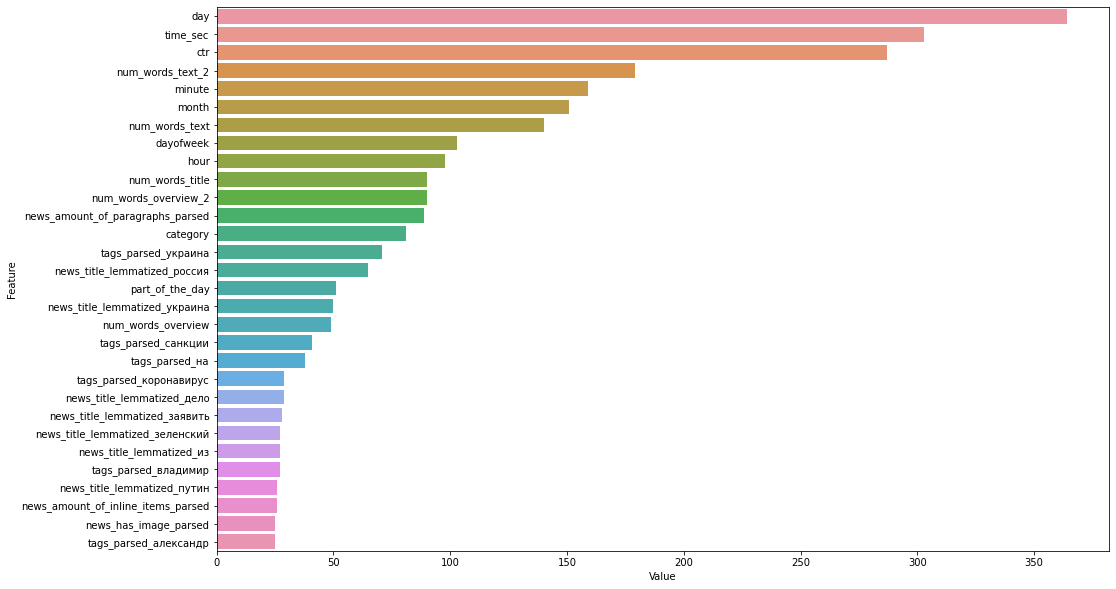

train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
[]
[]
[]
depth:  0.840320122722303


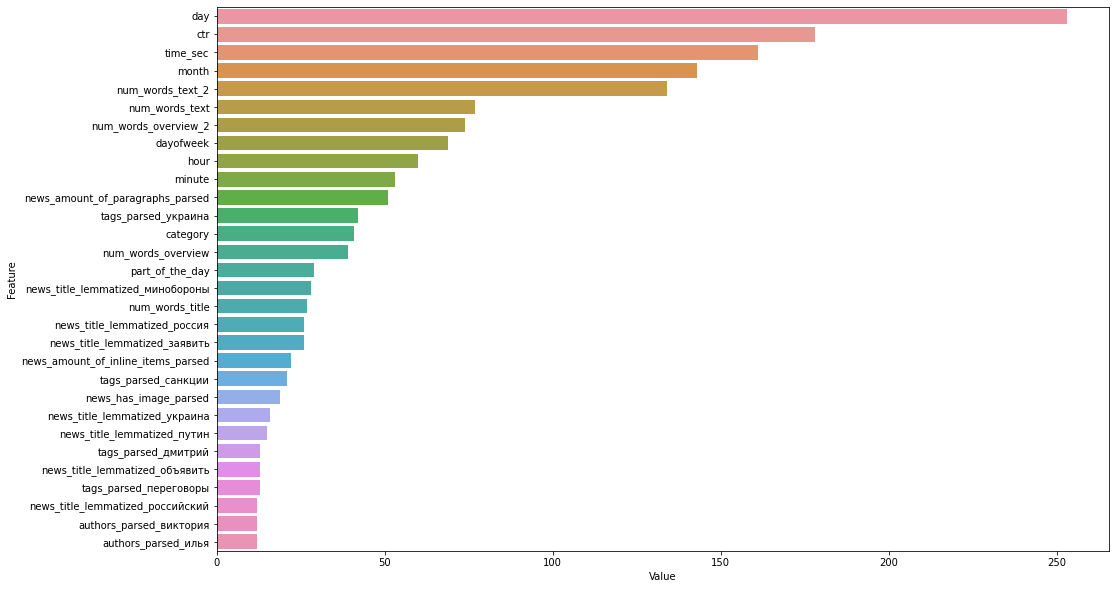

train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
[]
[]
[]
full_reads_percent:  0.5520526790441989


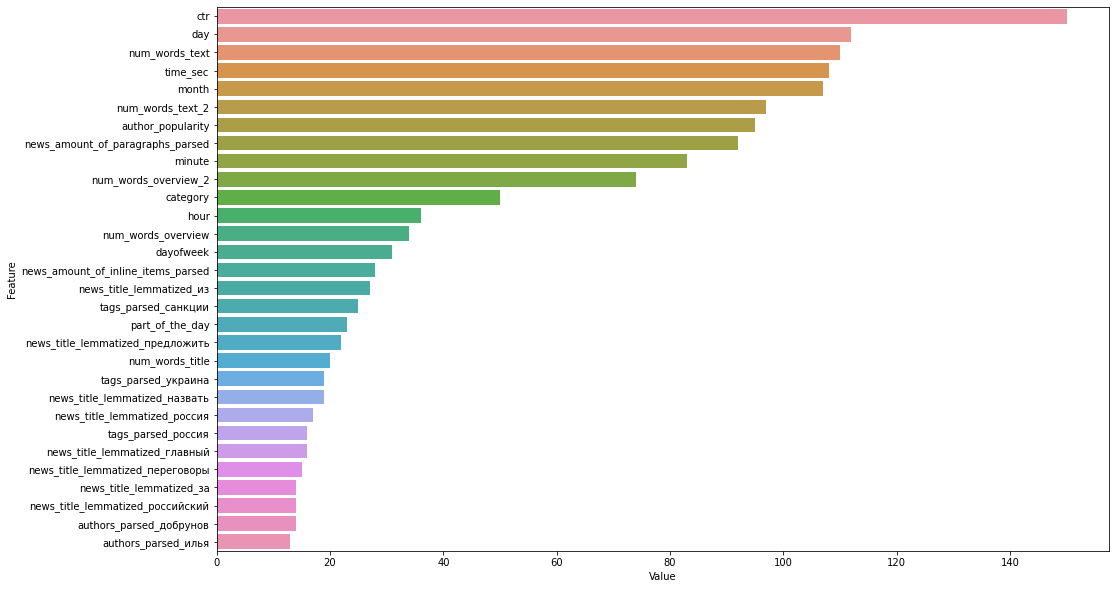

Final score: 0.7007146085371596, median: 0.702175787986902


In [53]:
result_dict = {
    'views': {'r2': [], 'trees': [], 'prediction': []},
    'full_reads_percent': {'r2': [], 'trees': [], 'prediction': []},
    'depth': {'r2': [], 'trees': [], 'prediction': []}
}
for target_variable in FeaturesConstants.target:
#     if target_variable in ['views', 'depth']:
#         continue
    FeatureGenerator = Compose(
        transforms=[
            DatetimeTransformer(full='use' if target_variable == 'full_reads_percent' else None),
            TitleTransformer(),
            CTRTransformer(eps=0.1 if target_variable == 'views' else 0.5),
            TagsTransformer(),
            AuthorsTransformer(),
            TextTransformer(use_text_transformer=target_variable if target_variable == 'full_reads_percent' else None),
            NatashaTextTransformer(),
            CategoryTransformer(),
            FeatureSelector()
        ]
    )
    train_features = FeatureGenerator(data=train_data, mode='train')
    test_features = FeatureGenerator(data=test_data, mode='test')
    
    tfidf = TfidfVectorTransformer(
        col='news_title_lemmatized',
        tfidf_vectorizer=TfidfVectorizer(
            ngram_range=(1, 4) if target_variable != 'full_reads_percent' else (1, 4),
            max_features=256 if target_variable != 'full_reads_percent' else 2048,
            min_df=3 if target_variable != 'full_reads_percent' else 1
        )
    )
    tfidf.fit(train_data)
    train_dd = tfidf.transform(train_data)
    test_dd = tfidf.transform(test_data)
    train_features = pd.concat([train_features, train_dd], axis=1)
    test_features = pd.concat([test_features, test_dd], axis=1)
    
        
    tfidf = TfidfVectorTransformer(
        col='tags_parsed',
        tfidf_vectorizer=TfidfVectorizer(
            ngram_range=(1, 4) if target_variable != 'full_reads_percent' else (1, 4),
            max_features=256 if target_variable != 'full_reads_percent' else 2048,
            min_df=5 if target_variable != 'full_reads_percent' else 1
        )
    )
    tfidf.fit(train_data)
    train_dd = tfidf.transform(train_data)
    test_dd = tfidf.transform(test_data)
    train_features = pd.concat([train_features, train_dd], axis=1)
    test_features = pd.concat([test_features, test_dd], axis=1)
    
    
    tfidf = TfidfVectorTransformer(
        col='authors_parsed',
        tfidf_vectorizer=TfidfVectorizer(
            ngram_range=(1, 4),
            max_features=128 if target_variable != 'views' else 64
        )
    )
    tfidf.fit(train_data)
    train_dd = tfidf.transform(train_data)
    test_dd = tfidf.transform(test_data)
    train_features = pd.concat([train_features, train_dd], axis=1)
    test_features = pd.concat([test_features, test_dd], axis=1)
    

    
    if target_variable == 'full_reads_percent':
        cec = CountTfIdfVectorizer(
            col='authors_parsed',
            count_vectorizer=CountVectorizer(
                ngram_range=(1, 4),
            )
        )
        cec.fit(train_data)
        train_features['author_popularity'] = cec.transform(train_data)
        test_features['author_popularity'] = cec.transform(test_data)
#     import copy
#     train_ebmeddings = copy.deepcopy(embeddings)
#     idx = train_ebmeddings.sum(axis=1) != 0
#     train_ebmeddings[idx] = train_ebmeddings[idx] / np.linalg.norm(train_ebmeddings[idx], ord=2,axis=1).reshape((-1,1))
#     train_features = pd.concat((train_features, pd.DataFrame(train_ebmeddings, index=train_features.index)), axis=1)
    
#     print(train_features.shape, test_features.shape)
    for train_index, val_index in kfold.split(train_features):
        X_train, X_valid = (
            train_features.reset_index(drop=True).iloc[train_index, :], 
            train_features.reset_index(drop=True).iloc[val_index, :]
        )
        y_train, y_valid = (
            y_data[target_variable].reset_index(drop=True).iloc[train_index], 
            y_data[target_variable].reset_index(drop=True).iloc[val_index]
        )
        if target_variable == 'views':
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
        elif target_variable == 'depth':
            y_train = np.log(np.log(y_train))
            y_valid = np.log(np.log(y_valid))
        else:
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
            
        if target_variable == 'me':
            pass
        else:
#             dtrain = lgb.Dataset(X_train, label=y_train)
#             dvalid = lgb.Dataset(X_valid, label=y_valid)            
            
            lgbm_regressor = lgb.LGBMRegressor(
                objective='regression',
                random_state=33,
                early_stopping_round=100, 
                n_estimators=500,
                subsample=0.01,
                colsample_bytree=0.7,
                learning_rate=0.08 if target_variable == 'full_reads_percent' else 0.08,
                max_depth=-1,
                verbose=-1
            )
            lgbm_regressor.fit(X_train, 
                     y_train, 
                     eval_set=[(X_valid, y_valid)], 
                     eval_metric='rmse', verbose=-1)
        y_pred = lgbm_regressor.predict(X_valid)
        r2 = r2_score(y_valid, y_pred)
        result_dict[target_variable]['r2'].append(r2)
        result_dict[target_variable]['trees'].append(lgbm_regressor.booster_.trees_to_dataframe())

        
        pro = lgbm_regressor.predict(test_features)
        if target_variable == 'views':
            pro = np.exp(pro)
        elif target_variable == 'depth':
            pro = np.exp(np.exp(pro))
        else:
            pro = np.exp(pro)
        print(pro[pro < 0])
        result_dict[target_variable]['prediction'].append(pro)
    print(f'{target_variable}: ', np.mean(result_dict[target_variable]['r2']))
    plotImp(lgbm_regressor, train_features, num=30, fig_size=(16, 10))

full_score = (
    np.mean(result_dict['views']['r2']) * 0.4 + 
    np.mean(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.mean(result_dict['depth']['r2']) * 0.3
)
full_score_2 = (
    np.median(result_dict['views']['r2']) * 0.4 + 
    np.median(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.median(result_dict['depth']['r2']) * 0.3
)
print(f'Final score: {full_score}, median: {full_score_2}')

# Sub4 - best

In [54]:
sub = pd.DataFrame(
    {
        'document_id': test_data['document_id'].values,
        'views': pd.DataFrame(result_dict['views']['prediction']).T.mean(axis=1),
        'depth': pd.DataFrame(result_dict['depth']['prediction']).T.mean(axis=1),
        'full_reads_percent': pd.DataFrame(result_dict['full_reads_percent']['prediction']).T.mean(axis=1),
    },
)
sub.index = test_data.index

In [55]:
sub_full = pd.concat((sub, exist_prediction)).sort_index()

In [56]:
ss = pd.read_csv('../sub/sample_solution.csv')

In [57]:
sub_full_2 = pd.DataFrame(ss['document_id'])

In [58]:
views = []
full_reads_percent = []
depth = []
for j, i in sub_full_2.iterrows():
    dummy = sub_full[sub_full['document_id'] == i['document_id']]
    views.append(dummy['views'].values[0])
    full_reads_percent.append(dummy['full_reads_percent'].values[0])
    depth.append(dummy['depth'].values[0])

In [59]:
sub_full_2['views'] = views
sub_full_2['full_reads_percent'] = full_reads_percent
sub_full_2['depth'] = depth

In [60]:
sub_full_2.to_csv(SUB_DIR / 'ERA_TFIDF_2.csv', index=False)